# Gaussian mixture model

The model in prototyped with TensorFlow Probability and inferecne is performed with variational Bayes by stochastic gradient descent. 
Details on [Wikipedia](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model).

Some codes are borrowed from 
[Brendan Hasz](https://brendanhasz.github.io/2019/06/12/tfp-gmm.html) and 
[TensorFlow Probability examples](https://www.tensorflow.org/probability/overview)

Author: Yuanhua Huang

Date: 29/01/2020

#### Definition of likelihood

Below is the definition of likelihood by marginalising the assignment probability of eac data point:

$$ L(\mu, \sigma, \pi | x) = \prod_{i=1}^N \prod_{j=1}^D \sum_{k=1}^K \pi_k \mathcal{N}(x_{ij}|\mu_{k,j}, \sigma_{k,j})$$

**Note**, this implementation is mainly for tutorial example, and hasn't been optimised, for example introducing multiple initialization to avoid local optimal caused by poor initialization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Random seed
np.random.seed(1)
tf.random.set_seed(1)

## Generate data

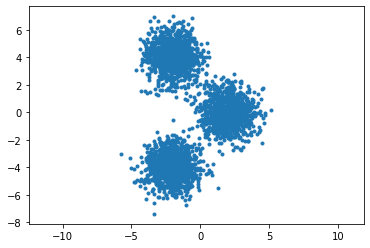

In [2]:
# Generate some data
np.random.seed(0)
N = 3000
X = np.random.randn(N, 2).astype('float32')
X[:1000, :] += [2, 0]
X[1000:2000, :] -= [2, 4]
X[2000:, :] += [-2, 4]

# Plot the data
plt.plot(X[:, 0], X[:, 1], '.')
plt.axis('equal')
plt.show()

## Define model

In [3]:
from TFBayes.mixture import GaussianMixture

In [4]:
model = GaussianMixture(3, 2)
model.set_prior(theta_prior = tfd.Dirichlet(5 * tf.ones((3, ))))
model.KLsum

<tf.Tensor: id=180, shape=(), dtype=float32, numpy=5.3464403>

In [5]:
# model.counts, model.alpha, model.beta, model.locs, model.scales

In [6]:
# losses = model.fit(X, sampling=False, learn_rate=0.03, num_steps=200)
losses = model.fit(X, sampling=True, learn_rate=0.02, num_steps=200, n_sample=50)

In [7]:
model.counts, model.alpha, model.beta, model.locs, model.scales

(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([3.426176 , 3.4373004, 3.46484  ], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[5.454983 , 4.310041 ],
        [5.0390167, 4.915546 ],
        [5.242698 , 3.360533 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[5.081805 , 5.5552278],
        [5.3075175, 5.6544127],
        [5.4874854, 6.6475215]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[-2.001296 ,  3.8940017],
        [ 1.9905602, -0.0084377],
        [-2.0611472, -3.7512407]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[0.03103204, 0.03759036],
        [0.03605201, 0.03453842],
        [0.03178168, 0.0415691 ]], dtype=float32)>)

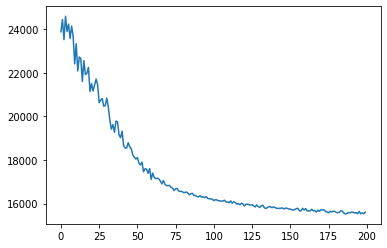

In [8]:
plt.plot(losses)
plt.show()

Text(0, 0.5, 'Likelihood')

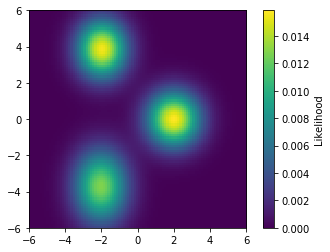

In [9]:
# Compute log likelihood at each point on a grid
Np = 100 #number of grid points
Xp, Yp = np.meshgrid(np.linspace(-6,6,Np), np.linspace(-6,6,Np))
Pp = np.column_stack([Xp.flatten(), Yp.flatten()])
Z = model.logLik(Pp.astype('float32'), sampling=False)
Z = np.reshape(Z, (Np, Np))
        
# Show the fit mixture density
plt.imshow(np.exp(Z),
           extent=(-6, 6, -6, 6),
           origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood')

## Model
The codes below is also included in [TFBayes.mixture.Gaussian_MM.py](https://github.com/huangyh09/TensorFlow-Bayes/blob/master/TFBayes/mixture/Gaussian_MM.py).

In [10]:
class GaussianMixture():
    """A Bayesian Gaussian mixture model.
    Assumes Gaussians' variances in each dimension are independent.
    
    Parameters
    ----------
    Nc : int > 0
        Number of mixture components.
    Nd : int > 0
        Number of dimensions.
    """
    def __init__(self, Nc, Nd):
        # Initialize
        self.Nc = Nc
        self.Nd = Nd
        
        # Variational distribution variables for means
        self.locs = tf.Variable(tf.random.normal((Nc, Nd)))
        self.scales = tf.Variable(tf.pow(tf.random.gamma((Nc, Nd), 5, 5), -0.5))
        
        # Variational distribution variables for standard deviations
        self.alpha = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        self.beta = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        
        # Variational distribution variables for component weights
        self.counts = tf.Variable(2 * tf.ones((Nc, )))
        
        self.set_prior()
        
    def set_prior(self, mu_prior=None, sigma_prior=None, theta_prior=None):
        """Set prior ditributions
        """
        # Prior distributions for the means
        if mu_prior is None:
            self.mu_prior = tfd.Normal(tf.zeros((self.Nc, self.Nd)), 
                                       tf.ones((self.Nc, self.Nd)))
        else:
            self.mu_prior = self.mu_prior

        # Prior distributions for the standard deviations
        if sigma_prior is None:
            self.sigma_prior = tfd.Gamma(2 * tf.ones((self.Nc, self.Nd)), 
                                         2 * tf.ones((self.Nc, self.Nd)))
        else:
            self.sigma_prior = sigma_prior
        
        # Prior distributions for the component weights
        if theta_prior is None:
            self.theta_prior = tfd.Dirichlet(5 * tf.ones((self.Nc, )))
        else:
            self.theta_prior = theta_prior
        
    @property
    def theta(self):
        """Variational posterior for the component size"""
        return tfd.Dirichlet(tf.math.exp(self.counts))

    @property
    def mu(self):
        """Variational posterior for distribution mean"""
        return tfd.Normal(self.locs, self.scales)
    
    @property
    def sigma(self):
        """Variational posterior for distribution variance"""
        return tfd.Gamma(self.alpha, self.beta)
        # return tfd.Gamma(tf.math.exp(self.alpha), tf.math.exp(self.beta))
        
    @property
    def KLsum(self):
        """Sum of KL divergences between posteriors and priors"""
        kl_mu    = tf.reduce_sum(tfd.kl_divergence(self.mu,    self.mu_prior))
        kl_sigma = tf.reduce_sum(tfd.kl_divergence(self.sigma, self.sigma_prior))
        kl_theta = tf.reduce_sum(tfd.kl_divergence(self.theta, self.theta_prior))
        
        return kl_mu + kl_sigma + kl_theta
    
        
    def logLik(self, x, sampling=True, n_sample=50):
        """Compute log likelihood given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor, (n_sample, n_dimention)
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
        n_sample : int
            The number of samples to generate
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        """
        #TODO: sampling doesn't converge well in the example data set
        # Broadcast to the shape: (n_sample, Nb, Nc, Nd)
        Nb, Nd = x.shape
        x = tf.reshape(x, (1, Nb, 1, Nd)) 

        # Sample from the variational distributions
        if sampling:
            _mu = self.mu.sample((n_sample, 1))
            _sigma = tf.pow(self.sigma.sample((n_sample, 1)), -0.5)
            _theta = tf.reshape(self.theta.sample((n_sample, 1)), 
                                      (n_sample, 1, self.Nc, 1))
        else:
            _mu = tf.reshape(self.mu.mean(), (1, 1, self.Nc, self.Nd))
            _sigma = tf.pow(tf.reshape(self.sigma.mean(), 
                                       (1, 1, self.Nc, self.Nd)), -0.5)
            _theta = tf.reshape(self.theta.mean(), (1, 1, self.Nc, 1))

        # Calculate the probability density
        _model = tfd.Normal(_mu, _sigma)
        _log_lik_mix = _model.log_prob(x) + tf.math.log(_theta)  
        log_likelihoods = tf.reduce_mean(tf.math.reduce_logsumexp(
            tf.reduce_sum(_log_lik_mix, axis=3), axis=2), axis=0)
        
        return log_likelihoods
    
    def fit(self, x, num_steps=200, 
            optimizer=None, learn_rate=0.05, **kwargs):
        """Fit the model's parameters"""
        if optimizer is None:
            optimizer = tf.optimizers.Adam(learning_rate=learn_rate)
            
        loss_fn = lambda: (self.KLsum - 
            tf.reduce_sum(self.logLik(x, **kwargs)))
        
        losses = tfp.math.minimize(loss_fn, 
                                   num_steps=num_steps, 
                                   optimizer=optimizer)
        return losses